



# Libraries

In [ ]:
# Installing the packages

!pip install prophet --q
!pip install tqdm --q

In [ ]:
!pip uninstall prophet fbprophet pystan cmdstanpy -y

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0


In [ ]:
!pip install prophet --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install optuna --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from prophet import Prophet
from prophet.diagnostics import cross_validation
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import tqdm
from prophet.diagnostics import cross_validation, performance_metrics
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Important Function

In [ ]:
# adding seasons

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

In [ ]:
# Function to add features

def feature_creation(train):

  train['year'] = train['ds'].dt.year
  train['month'] = train['ds'].dt.month
  train['day'] = train['ds'].dt.day
  train['weekday_numeric'] = train['ds'].dt.weekday
  train['is_weekend'] = (train['ds'].dt.weekday > 4).astype(int)
  train['weekday'] = train['ds'].dt.day_name()
  train['quarter'] = train['ds'].dt.quarter

  # Seasons
  train["season"] = train["month"].apply(get_season)


  # Adding Holidays as a Binary Feature
  cal = calendar()

  holidays = cal.holidays(start=train['ds'].min(),
                          end=train['ds'].max(),
                          return_name=True)
  holiday_df = pd.DataFrame(data=holidays,
                            columns=['holiday'])
  holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

  # Convert to strings (only date part)
  train['date_str'] = train['ds'].astype(str).str[:10]
  holiday_df['date_str'] = holiday_df['ds'].astype(str).str[:10]

  # Create a holiday flag
  train['holiday'] = (
      train['date_str'].isin(holiday_df['date_str'])
      | train['date_str'].isin(['2002-01-01', '2002-01-21'])
      | train['date_str'].isin(train.loc[train['is_weekend'] == 1, 'date_str'])
  )

  train['holiday'] = train['holiday'].astype(int)

  # Removing the date str column
  train.drop('date_str', axis = 1, inplace = True)


  # adding lag features
  # 1-hour lag
  train['lag_1h'] = train['y'].shift(1)

  # 24-hour lag
  train['lag_1day'] = train['y'].shift(24)

  # 168-hour lag (1 week)
  train['lag_1week'] = train['y'].shift(168)

  # adding rolling features
  train['7-Day MA'] = train['y'].rolling(window = 24*7).mean() # 7-day rolling average
  train['30-Day MA'] = train['y'].rolling(window = 24*30).mean() # 30-day rolling average
  train['200-Day MA'] = train['y'].rolling(window = 24*200).mean() # 200-day rolling average

In [ ]:
def accuracy_metric(ytest, ypred):
  mae = mean_absolute_error(ytest, ypred)
  rmse = np.sqrt(mean_squared_error(ytest, ypred))
  mape = mean_absolute_percentage_error(ytest, ypred)

  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape*100:.4f} %')

In [ ]:
def cross_val_acc(model, X_train, y_train):
  mape = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
  rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean())
  mae = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error').mean()

  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape*100:.4f} %')

# Data

In [ ]:
#reading the dataset
df = pd.read_csv("PJME_hourly.csv",
                 parse_dates = ['Datetime']
                 )

In [ ]:
df.head() # having a look at the dataset

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.info() # checking the datatypes and the number of non null values here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [ ]:
df.isna().sum()

,0
Datetime,0
PJME_MW,0


## Handling Duplicates

In [ ]:
# checking for duplicate values

duplicates = df[df.duplicated(subset = ['Datetime'], keep = False)]
print(duplicates)

                  Datetime  PJME_MW
106584 2014-11-02 02:00:00  22935.0
106585 2014-11-02 02:00:00  23755.0
115368 2015-11-01 02:00:00  21567.0
115369 2015-11-01 02:00:00  21171.0
124008 2016-11-06 02:00:00  20795.0
124009 2016-11-06 02:00:00  21692.0
132816 2017-11-05 02:00:00  21236.0
132817 2017-11-05 02:00:00  20666.0


In [ ]:
# handling the duplicate values
# Taking the average of the Energy consumed

df = df.groupby('Datetime').agg({
    'PJME_MW': 'mean',
    'Datetime': 'first'
    })

In [ ]:
df.isna().sum()

,0
PJME_MW,0
Datetime,0


In [ ]:
# setting datetime column as index

df = df.set_index('Datetime')

In [ ]:
# setting the frequency to hourly

df = df.asfreq(freq = 'h')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [ ]:
df['PJME_MW'].isna().sum()

np.int64(30)

In [ ]:
df.isna().sum()

,0
PJME_MW,30


In [ ]:
df.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145392, freq='h')

In [ ]:
# renaming

df = df.rename(columns = {'PJME_MW': 'y'})
df = df.reset_index().rename(columns = {'Datetime': 'ds'})

df.head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


In [ ]:
df['y'].isna().sum()

np.int64(30)

# Train Test Split

In [ ]:
# splitting the dataset

train, test = np.split(df, [int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


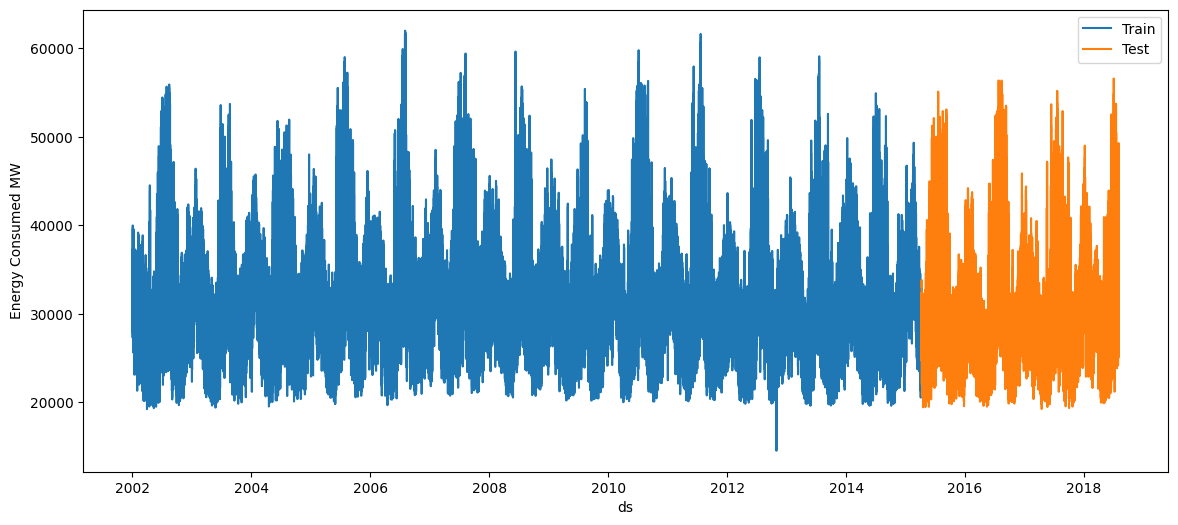

In [ ]:
# Plotting the Training and Test Dataset

plt.figure(figsize = (14, 6))
sns.lineplot(y = train['y'], x = train['ds'], label = 'Train')
sns.lineplot(y = test['y'], x = test['ds'], label = 'Test')
plt.ylabel('Energy Consumed MW')
plt.legend()
plt.show()

# Feature Engineering

## Feature Creation



In [ ]:
# Creating Features for the Train set

feature_creation(train)

In [ ]:
# Creating Features for the Test set

feature_creation(test)

## Missing Value Imputation


In [ ]:
# checking the number of missing values

missing_values = {
  'Train': train.isna().sum(),
  'Test': test.isna().sum()
  }

missing_df = pd.DataFrame(data = missing_values)

missing_df

,Train,Test
ds,0,0
y,27,3
year,0,0
month,0,0
day,0,0
weekday_numeric,0,0
is_weekend,0,0
weekday,0,0
quarter,0,0
season,0,0


In [ ]:
train = train.fillna(method='ffill').fillna(method='bfill')
test = test.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-2300195387.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2300195387.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='ffill').fillna(method='bfill')


In [ ]:
missing_values_after = {
  'Train': train.isna().sum(),
  'Test': test.isna().sum()
  }

missing_df_after = pd.DataFrame(data = missing_values_after)

missing_df_after

,Train,Test
ds,0,0
y,0,0
year,0,0
month,0,0
day,0,0
weekday_numeric,0,0
is_weekend,0,0
weekday,0,0
quarter,0,0
season,0,0


# Data Visualization

In [ ]:
# EDA on the training set

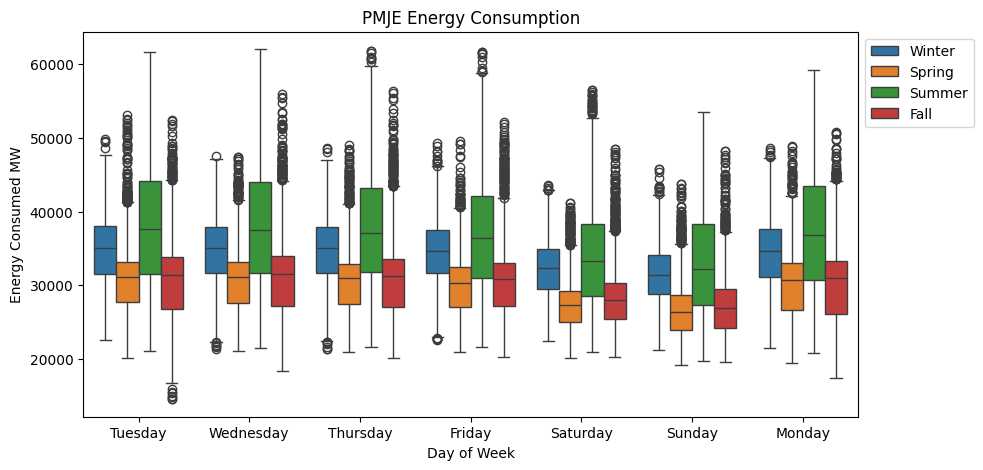

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=train,
            x='weekday',
            y='y',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('PMJE Energy Consumption')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy Consumed MW')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

 ## **Statistical Interpretation (Boxplot Meaning)**

For each season–day combination:

- The **box** shows the **interquartile range (IQR)** — 25th to 75th percentile.  
- The **line inside the box** is the **median energy consumption**.  
- The **whiskers** represent the general spread, while **dots** are **outliers** (days with unusually high or low demand).  

This helps us observe not just central tendency but also variability and anomalies across seasons and weekdays.

---

 **Key Observations & Insights**

###  Winter (Blue Boxes)

- Higher median consumption compared to other seasons, typically in the **30,000–35,000 MW** range.  
- Relatively wide spread, suggesting significant fluctuations in energy usage (likely driven by heating needs).  
- Outliers extend up to **~60,000 MW**, indicating occasional extreme cold days with very high demand.  
- Consumption is fairly consistent across days, showing steady weekday demand and only mild drops on weekends.  

**Interpretation:**  
Winter months likely see consistently high baseline energy demand due to heating requirements, with less variation by weekday/weekend.

---

###  Summer (Green Boxes)

- Highest consumption levels overall, with medians ranging around **40,000 MW**, and outliers reaching **60,000+ MW**.  
- Large variability, as shown by wide boxes and long whiskers — peak loads likely due to air conditioning and cooling demands.  
- Weekdays (especially Monday–Friday) have slightly higher medians than weekends, hinting at strong commercial/industrial usage.  

**Interpretation:**  
Summer is the **peak load season**, with highly volatile energy usage reflecting hot-weather spikes in demand.  
Monday and Friday appear to be heavier load days, suggesting cyclical business-related patterns.

---

###  Spring (Orange Boxes)

- Lowest median consumption, around **27,000–30,000 MW**.  
- Tight box range, indicating **low variability**.  
- Fewer outliers overall — meaning stable energy patterns across days.  
- Saturday and Sunday don’t show any unusual dips or rises.  

**Interpretation:**  
Spring represents a **low-demand and stable period**, likely due to moderate temperatures reducing both heating and cooling needs.  
Predictability is high, which is favorable for forecasting and grid management.

---

###  Fall (Red Boxes)

- Slightly higher than Spring but still below Winter and Summer levels — medians around **30,000–32,000 MW**.  
- Shows **moderate spread**, suggesting transitional energy behavior (mix of cooling and heating days).  
- Weekday consumption (especially Friday and Monday) is slightly elevated, but weekends are similar.  

**Interpretation:**  
Fall acts as a **shoulder season** — energy usage begins to rise as heating returns but hasn’t yet reached winter intensity.

---

 **4. Cross-Season Comparisons by Day**

| Day | Highest Season | Lowest Season | Notable Pattern |
|-----|----------------|----------------|-----------------|
| Monday | Summer | Spring | Strong industrial start-of-week demand in Summer |
| Tuesday–Friday | Summer | Spring | Steady mid-week consumption peaks |
| Saturday–Sunday | Summer | Spring | Weekend dip less pronounced in Summer/Winter, more stable year-round |

**Interpretation:**  
Energy usage is **seasonally dominant** — the effect of the season is stronger than the effect of weekday/weekend variation.  
Summer and Winter drive the extremes, while Spring and Fall act as stabilizers.

---

 **Business/Operational Insights**

- **Peak load management:** Highest strain on the grid occurs during **Summer weekdays**, indicating the need for demand response strategies (e.g., load shifting or time-of-use pricing).  
- **Predictive modeling:** Seasonal and weekday features are strong predictors — include both in time series forecasting models.  
- **Energy planning:**  
  - Plan **maintenance** during **Spring and Fall** (lowest demand).  
  - Increase **generation capacity or imports** during **Summer**.  
- **Forecasting insight:** Expect larger prediction error margins during Summer due to high variability; use **rolling averages** or **Prophet with additional regressors** (temperature, humidity).


# One Hot Encoding

In [ ]:
# Now, One Hot Encoding the Categorical columns, i.e., weekday and season

ohe = OneHotEncoder(sparse_output=False).set_output(transform = 'pandas')
ohe_transform_train = ohe.fit_transform(train[['weekday', 'season']])
ohe_transform_test = ohe.transform(test[['weekday', 'season']])

In [ ]:
train = pd.concat([ohe_transform_train, train], axis = 1).drop(columns = ['weekday', 'season'])
test = pd.concat([ohe_transform_test, test], axis = 1).drop(columns = ['weekday', 'season'])

In [ ]:
train.columns, test.columns

(Index(['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
        'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
        'weekday_Wednesday', 'season_Fall', 'season_Spring', 'season_Summer',
        'season_Winter', 'ds', 'y', 'year', 'month', 'day', 'weekday_numeric',
        'is_weekend', 'quarter', 'holiday', 'lag_1h', 'lag_1day', 'lag_1week',
        '7-Day MA', '30-Day MA', '200-Day MA'],
       dtype='object'),
 Index(['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
        'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
        'weekday_Wednesday', 'season_Fall', 'season_Spring', 'season_Summer',
        'season_Winter', 'ds', 'y', 'year', 'month', 'day', 'weekday_numeric',
        'is_weekend', 'quarter', 'holiday', 'lag_1h', 'lag_1day', 'lag_1week',
        '7-Day MA', '30-Day MA', '200-Day MA'],
       dtype='object'))

In [ ]:
train.head(2)

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_Fall,season_Spring,season_Summer,...,weekday_numeric,is_weekend,quarter,holiday,lag_1h,lag_1day,lag_1week,7-Day MA,30-Day MA,200-Day MA
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,1,1,30393.0,30393.0,30393.0,32519.511905,31090.741667,32595.975417
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,1,1,30393.0,30393.0,30393.0,32519.511905,31090.741667,32595.975417


# Correlation between each features

In [ ]:
train.corr()['y']

,y
weekday_Friday,0.038958
weekday_Monday,0.037856
weekday_Saturday,-0.125393
weekday_Sunday,-0.175676
weekday_Thursday,0.068097
weekday_Tuesday,0.076480
weekday_Wednesday,0.079569
season_Fall,-0.220029
season_Spring,-0.274711
season_Summer,0.360966


# Model

## Prophet

In [ ]:
regressors = [
    'year', 'month', 'day', 'weekday_numeric', 'is_weekend',
    'quarter', 'holiday', 'lag_1h', 'lag_1day', 'lag_1week', '7-Day MA',
    '30-Day MA', '200-Day MA', 'weekday_Friday', 'weekday_Monday',
    'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
    'weekday_Tuesday', 'weekday_Wednesday', 'season_Fall', 'season_Spring',
    'season_Summer', 'season_Winter'
]

In [ ]:
%%time
model_prophet = Prophet(seasonality_mode='multiplicative')

for reg in regressors:
    model_prophet.add_regressor(reg)

model_prophet.fit(train)

CPU times: user 17.6 s, sys: 918 ms, total: 18.5 s
Wall time: 1min 50s


In [ ]:
# Predict on test set with model

test_predict = model_prophet.predict(test)

In [ ]:
test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,200-Day MA,200-Day MA_lower,200-Day MA_upper,30-Day MA,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-04-09 10:00:00,31476.411700,33037.667290,35095.542618,31476.411700,31476.411700,0.000283,0.000283,0.000283,0.001549,...,0.001001,0.001001,0.001001,-0.005945,-0.005945,-0.005945,0.0,0.0,0.0,34105.479721
1,2015-04-09 11:00:00,31476.410698,32594.037401,34765.185681,31476.410698,31476.410698,0.000283,0.000283,0.000283,0.001549,...,0.001001,0.001001,0.001001,-0.005947,-0.005947,-0.005947,0.0,0.0,0.0,33651.072365
2,2015-04-09 12:00:00,31476.409695,32637.125740,34718.023175,31476.409695,31476.409695,0.000283,0.000283,0.000283,0.001549,...,0.001001,0.001001,0.001001,-0.005949,-0.005949,-0.005949,0.0,0.0,0.0,33604.643157
3,2015-04-09 13:00:00,31476.408693,32472.067565,34509.727461,31476.408693,31476.408693,0.000283,0.000283,0.000283,0.001549,...,0.001001,0.001001,0.001001,-0.005951,-0.005951,-0.005951,0.0,0.0,0.0,33399.949871
4,2015-04-09 14:00:00,31476.407690,31988.888914,34065.878038,31476.407690,31476.407690,0.000283,0.000283,0.000283,0.001549,...,0.001001,0.001001,0.001001,-0.005953,-0.005953,-0.005953,0.0,0.0,0.0,33038.641771


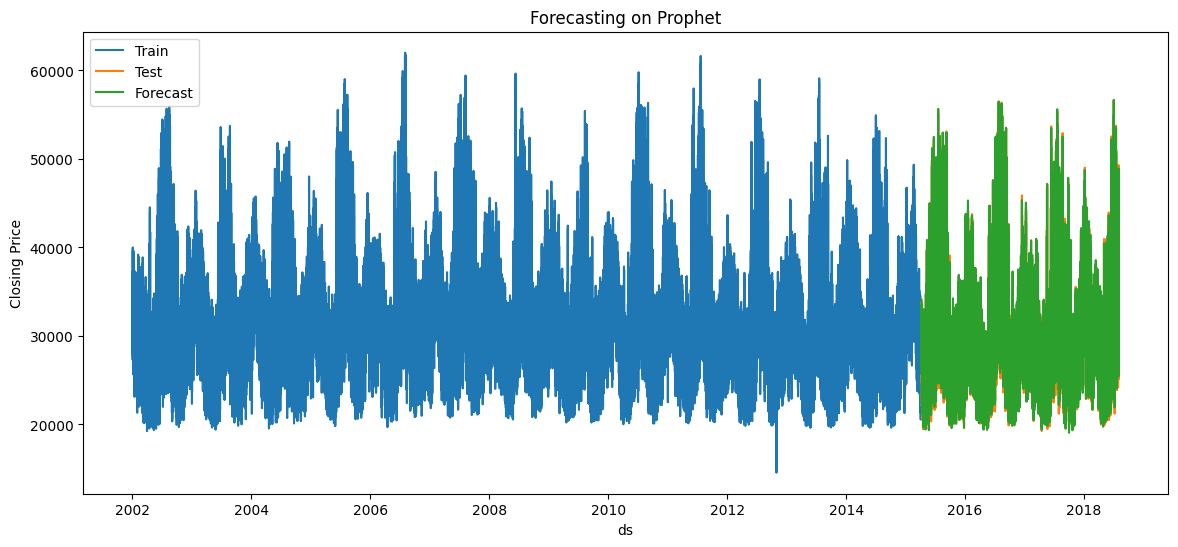

In [ ]:
# Plotting the Train Test and Forecasted Values

plt.figure(figsize = (14, 6))
sns.lineplot(y = train['y'], x = train['ds'], label = 'Train')
sns.lineplot(y = test['y'], x = test['ds'], label = 'Test')
sns.lineplot(y = test_predict['yhat'], x = test_predict['ds'], label = 'Forecast')
plt.title('Forecasting on Prophet')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
# Checking the Error Metrics
accuracy_metric(test['y'], test_predict['yhat'])

MAE: 604.0401567570966
RMSE: 792.5798154586403
MAPE: 1.9070 %


### Parameter Tuning

In [ ]:
# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive'])
    changepoint_prior_scale = trial.suggest_categorical('changepoint_prior_scale', [0.001, 0.01, 0.05, 0.1])
    seasonality_prior_scale = trial.suggest_categorical('seasonality_prior_scale', [1.0, 5.0, 10.0])

    # Create the RandomForestClassifier with suggested hyperparameters
    model = Prophet(
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale = seasonality_prior_scale
    )

    for reg in regressors:
      model.add_regressor(reg)

    model.fit(train)

    df_cv = cross_validation(
      model,
      initial='80000 hours',    # first training window
      period='15876 hours',     # spacing between cutoffs
      horizon='4560 hours',     # forecast horizon
      parallel="processes"
    )


    # Compute performance metric
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape = df_p['mape'].values[0]  # average MAPE
    return mape  # minimize MAPE

In [ ]:
train.shape

(116313, 26)

In [ ]:
# Create a study object and optimize the objective function
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar = True)  # Run 50 trials to find the best hyperparameters

[I 2025-10-25 03:30:52,173] A new study created in memory with name: no-name-d2c00f9b-63af-45e7-b2fc-92e63fe3dc2b


  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/37l77f1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/pbth592q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/vov73eqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67534', 'data', 'file=/tmp/tmptp2fqijj/37l77f1o.json', 'init=/tmp/tmptp2fqijj/vov73eqq.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelp22tavxi/prophet_model-20251025033125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/5e96jb4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14967', 'data

[I 2025-10-25 03:35:31,003] Trial 1 finished with value: 0.018511488155217835 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/ywpqbgqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/dkym2sc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1248', 'data', 'file=/tmp/tmptp2fqijj/ywpqbgqj.json', 'init=/tmp/tmptp2fqijj/dkym2sc8.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_model7dofgnyb/prophet_model-20251025033554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[I 2025-10-25 03:36:29,009] Trial 0 finished with value: 0.01851883206016571 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/etdnsam5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/8dco4qhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69930', 'data', 'file=/tmp/tmptp2fqijj/etdnsam5.json', 'init=/tmp/tmptp2fqijj/8dco4qhx.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_model_wbk4iwf/prophet_model-20251025033652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c52003c9dc0>
DEBUG:cmdstanpy:input tempfile: 

[I 2025-10-25 03:43:46,225] Trial 2 finished with value: 0.018545433208344484 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/1q_mlfes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/lus956r_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88887', 'data', 'file=/tmp/tmptp2fqijj/1q_mlfes.json', 'init=/tmp/tmptp2fqijj/lus956r_.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelav6k1fp5/prophet_model-20251025034411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:44:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[I 2025-10-25 03:44:40,606] Trial 3 finished with value: 0.018541454965106726 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/rzfp5is5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/i9bz2ia8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33026', 'data', 'file=/tmp/tmptp2fqijj/rzfp5is5.json', 'init=/tmp/tmptp2fqijj/i9bz2ia8.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelggboepfs/prophet_model-20251025034504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:45:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c52186ade20>
DEBUG:cmdstanpy:input tempfile: 

[I 2025-10-25 03:52:44,290] Trial 5 finished with value: 0.018535077408647235 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/xat1jy_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/t_d_mr2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58580', 'data', 'file=/tmp/tmptp2fqijj/xat1jy_v.json', 'init=/tmp/tmptp2fqijj/t_d_mr2v.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelrxw1wwxv/prophet_model-20251025035307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c52003a9bb0>
DEBUG:cmdstanpy:input tempfile: 

[I 2025-10-25 03:54:36,010] Trial 4 finished with value: 0.01852685473276134 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/rhz49chv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/okzycw4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12967', 'data', 'file=/tmp/tmptp2fqijj/yar8ibdb.json', 'init=/tmp/tmptp2fqijj/okzycw4l.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelk1nu6iih/prophet_model-20251025035449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/g4oick07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14540', 'data', 'file=/tmp/tmptp2fqijj/0s92ci_2.json', 'init=/tmp/tmptp2fqij

[I 2025-10-25 03:57:33,456] Trial 6 finished with value: 0.018516076676403058 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/d0cnp4tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/irablp_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97543', 'data', 'file=/tmp/tmptp2fqijj/d0cnp4tj.json', 'init=/tmp/tmptp2fqijj/irablp_0.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_model_7g_fcyo/prophet_model-20251025035757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:58:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c5203737920>
DEBUG:cmdstanpy:input tempfile: 

[I 2025-10-25 04:06:49,574] Trial 8 finished with value: 0.01853678503216136 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/98d7ofet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/qtmed96o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87806', 'data', 'file=/tmp/tmptp2fqijj/98d7ofet.json', 'init=/tmp/tmptp2fqijj/qtmed96o.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_model9fs210c3/prophet_model-20251025040713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[I 2025-10-25 04:08:17,403] Trial 7 finished with value: 0.01851283925786455 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/pbvbfegw.json
04:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c520042c4d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/daqbn0mp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/1yybnm7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/68zb3l7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48172', 'data', 'file=/tmp/tmptp2fqijj/pbvbfegw.json', 'init=/tmp/tmptp2fqijj/68zb3l7v.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelu9teu35n/prophet_model-20251025040851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:08

[I 2025-10-25 04:12:10,487] Trial 9 finished with value: 0.01851883206016571 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/ohtqq_kq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/teoi2i1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17110', 'data', 'file=/tmp/tmptp2fqijj/ohtqq_kq.json', 'init=/tmp/tmptp2fqijj/teoi2i1a.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_model9d4mff05/prophet_model-20251025041250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/vlh2d9_4.json
04:13:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/co6f7gao.json
DEBUG:cmdstanpy:idx

[I 2025-10-25 04:14:49,649] Trial 10 finished with value: 0.018514530258002187 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/qcf1jzvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/bjfreglr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46135', 'data', 'file=/tmp/tmptp2fqijj/imi18rpn.json', 'init=/tmp/tmptp2fqijj/bjfreglr.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_models3kji7yo/prophet_model-20251025041454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/_3mby0lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38889', 'data', 'file=/tmp/tmptp2fqijj/dpj3k146.json', 'init=/tmp/tmptp2fqij

[I 2025-10-25 04:17:39,952] Trial 11 finished with value: 0.018516076676403058 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/gm5kx7nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/fqp280y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/thjo698b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/orug5dzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72884', 'data', 'file=/tmp/tmptp2fqijj/gm5kx7nn.json', 'init=/tmp/tmptp2fqijj/orug5dzq.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelmyzzlam5/prophet_model-20251025041810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/oxnnxecs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/proph

[I 2025-10-25 04:21:26,569] Trial 12 finished with value: 0.018514530258002187 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/5womcq6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/yfp0v6yq.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83296', 'data', 'file=/tmp/tmptp2fqijj/_s63nk7b.json', 'init=/tmp/tmptp2fqijj/5womcq6a.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modelbzaggipf/prophet_model-20251025042128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/c0lchxsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81305', 'data', 'file=/tmp/tmptp2fqijj/yfp0v6yq.json', 'init=/tmp/tmptp2fqij

[I 2025-10-25 04:24:31,965] Trial 13 finished with value: 0.018514530258002187 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}. Best is trial 1 with value: 0.018511488155217835.


DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/98g5ow8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptp2fqijj/uqek5s_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45481', 'data', 'file=/tmp/tmptp2fqijj/98g5ow8x.json', 'init=/tmp/tmptp2fqijj/uqek5s_2.json', 'output', 'file=/tmp/tmptp2fqijj/prophet_modely68natk5/prophet_model-20251025042457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2011-02-16 09:00:00 and 2014-10-01 09:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c5200636f30>
DEBUG:cmdstanpy:input tempfile: 

[W 2025-10-25 04:30:23,184] Trial 14 failed with parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0} because of the following error: KeyboardInterrupt().
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.12/concurrent/futures/process.py", line 264, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/process.py", line 213, in _process_chunk
    return [fn(*args) for args in chunk]
            ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/prophet/diagnostics.py", line 246, in single_cutoff_forecast
    m.fit(history_c, **model.fit_kwargs)
  File "/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py", line 1235, in fit
    self.params = self.stan_backend.fit(stan_init, dat, **kwargs)
                  ^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

Stopped because after Trial-1 it did not find a less mape than before

In [ ]:
# Best trial
print(study.best_trial.params)
print(study.best_trial.value)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}
0.018511488155217835


These are the best parameters to be used in prophet to get the best model

In [ ]:
# All completed trials as a DataFrame
df_trials = study.trials_dataframe()
df_trials.head()

,number,value,datetime_start,datetime_complete,duration,params_changepoint_prior_scale,params_seasonality_mode,params_seasonality_prior_scale,state
0,0,0.018519,2025-10-25 03:30:52.197371,2025-10-25 03:36:29.009810,0 days 00:05:36.812439,0.010,additive,1.0,COMPLETE
1,1,0.018511,2025-10-25 03:30:52.199175,2025-10-25 03:35:31.003301,0 days 00:04:38.804126,0.001,additive,1.0,COMPLETE
2,2,0.018545,2025-10-25 03:35:31.016845,2025-10-25 03:43:46.224861,0 days 00:08:15.208016,0.100,additive,10.0,COMPLETE
3,3,0.018541,2025-10-25 03:36:29.016006,2025-10-25 03:44:40.606246,0 days 00:08:11.590240,0.100,additive,1.0,COMPLETE
4,4,0.018527,2025-10-25 03:43:46.235024,2025-10-25 03:54:36.010396,0 days 00:10:49.775372,0.100,multiplicative,5.0,COMPLETE


In [ ]:
best_params_mape = df_trials[df_trials['value'] == df_trials['value'].min()].transpose()
best_params_mape

,1
number,1
value,0.018511
datetime_start,2025-10-25 03:30:52.199175
datetime_complete,2025-10-25 03:35:31.003301
duration,0 days 00:04:38.804126
params_changepoint_prior_scale,0.001
params_seasonality_mode,additive
params_seasonality_prior_scale,1.0
state,COMPLETE


Below, we are fitting a Prophet Model with the best parameters obtained

In [ ]:
%%time
model_prophet_best = Prophet(
    changepoint_prior_scale	= 0.001,
    seasonality_mode = 'additive',
    seasonality_prior_scale	= 1.0
)

for reg in regressors:
    model_prophet_best.add_regressor(reg)

model_prophet_best.fit(train)

CPU times: user 15.6 s, sys: 1.42 s, total: 17 s
Wall time: 43.9 s


In [ ]:
# Predict on test set with model

test_predict_best = model_prophet_best.predict(test)

In [ ]:
test_predict_best.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,200-Day MA,200-Day MA_lower,200-Day MA_upper,30-Day MA,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-09 10:00:00,33385.462177,33060.031235,35161.957606,33385.462177,33385.462177,3.945444,3.945444,3.945444,26.336905,...,-1271.699104,-1271.699104,-1271.699104,-180.428148,-180.428148,-180.428148,0.0,0.0,0.0,34088.268620
1,2015-04-09 11:00:00,33385.482894,32619.124241,34701.379867,33385.482894,33385.482894,3.945444,3.945444,3.945444,26.336905,...,-1271.699104,-1271.699104,-1271.699104,-180.458738,-180.458738,-180.458738,0.0,0.0,0.0,33633.002650
2,2015-04-09 12:00:00,33385.503611,32570.496764,34581.299500,33385.503611,33385.503611,3.945444,3.945444,3.945444,26.336905,...,-1271.699104,-1271.699104,-1271.699104,-180.489156,-180.489156,-180.489156,0.0,0.0,0.0,33586.648141


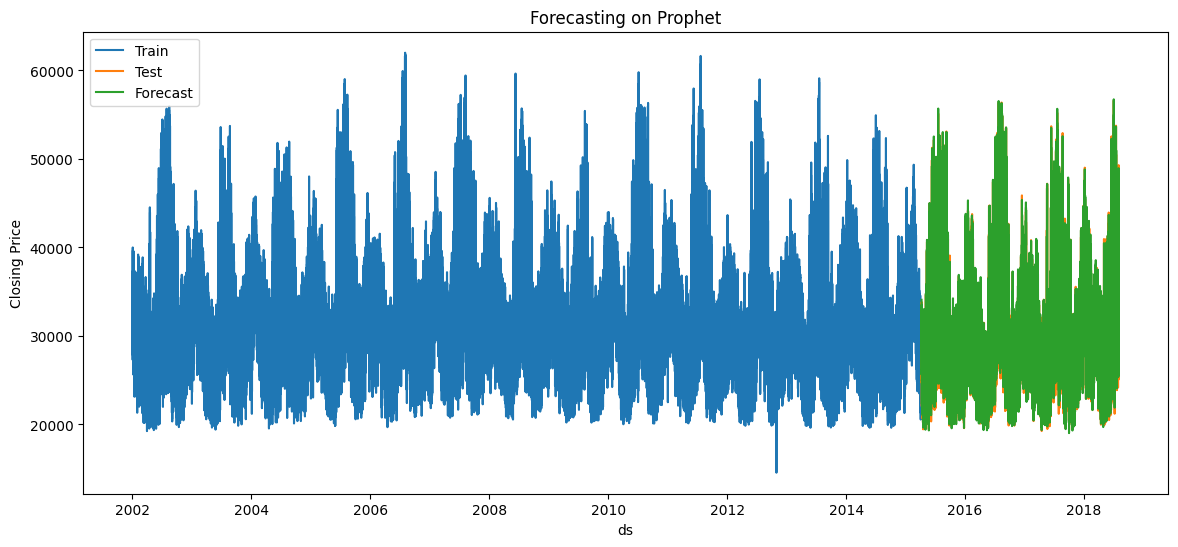

In [ ]:
# Plotting the Train Test and Forecasted Values

plt.figure(figsize = (14, 6))
sns.lineplot(y = train['y'], x = train['ds'], label = 'Train')
sns.lineplot(y = test['y'], x = test['ds'], label = 'Test')
sns.lineplot(y = test_predict_best['yhat'], x = test_predict_best['ds'], label = 'Forecast')
plt.title('Forecasting on Prophet')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

The Prophet model with the best parameters is showing great results as we can infer from the plot above

In [ ]:
# Checking the Error Metrics
accuracy_metric(test['y'], test_predict_best['yhat'])

MAE: 603.0564484070949
RMSE: 791.8606407042984
MAPE: 1.9029 %


We can clearly see a slight decrease in all of the Error Metrics

## SARIMAX

In [ ]:
# Not using ARIMA and SARIMA because we clearly know that this data has seasonality and depends on Exogeneous variable

### Seasonality

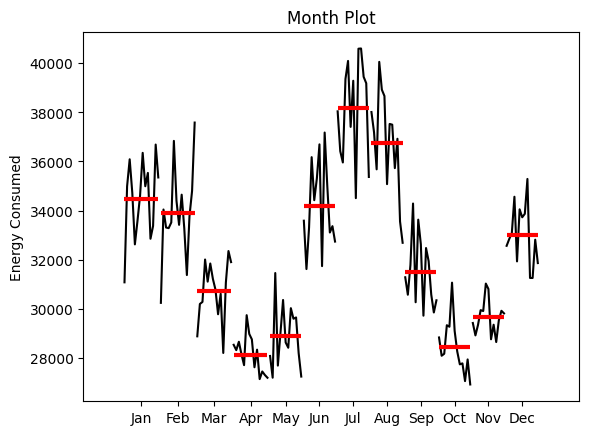

In [ ]:
# Month Plot
# Red lines indicate the mean values for each month

month_plot(train['y'].resample('ME').mean(),
           ylabel = 'Energy Consumed')
plt.title('Month Plot')
plt.show()

Here we can see that there is a monthly seasonality in the data

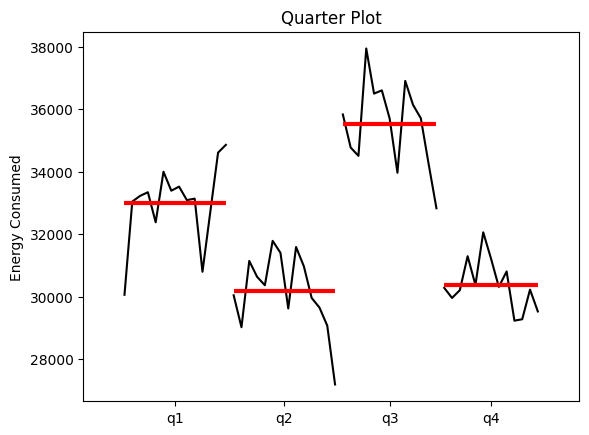

In [ ]:
# Quarter Plot
# Red lines indicate the mean values of each quarter

quarter_plot(train['y'].resample('QE').mean(),
             ylabel = 'Energy Consumed')
plt.title('Quarter Plot')
plt.show()

Similarly, there is a quarterly seasonality as well

In [ ]:
# Seasonal Decomposition

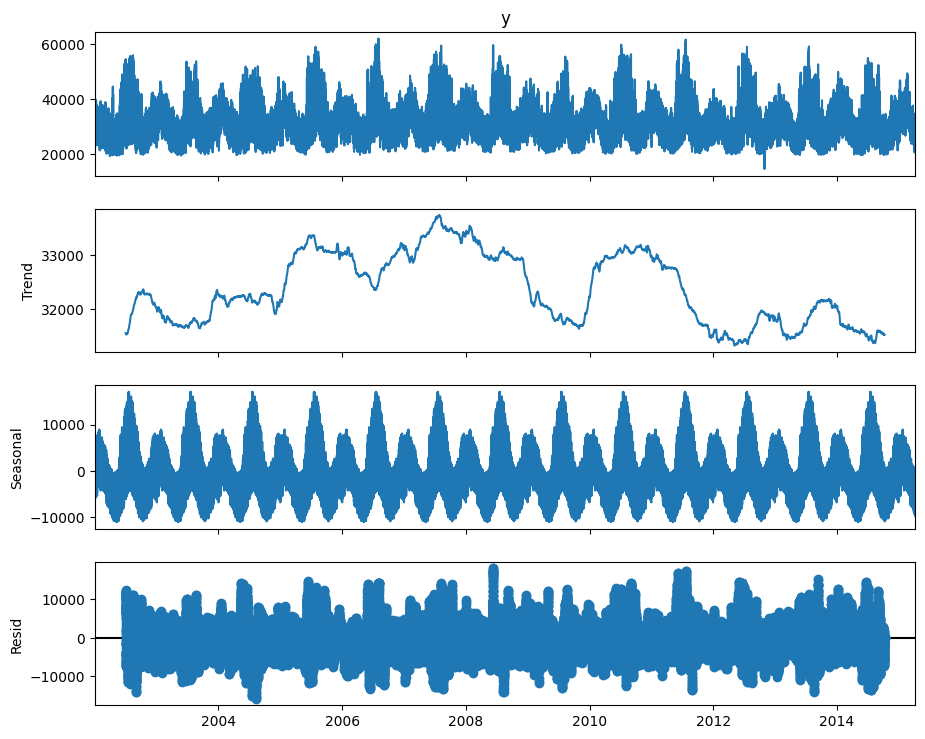

In [ ]:
decomposition = seasonal_decompose(train['y'],
                                   model = 'add',
                                   period = 365*24)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

### ACF & PACF

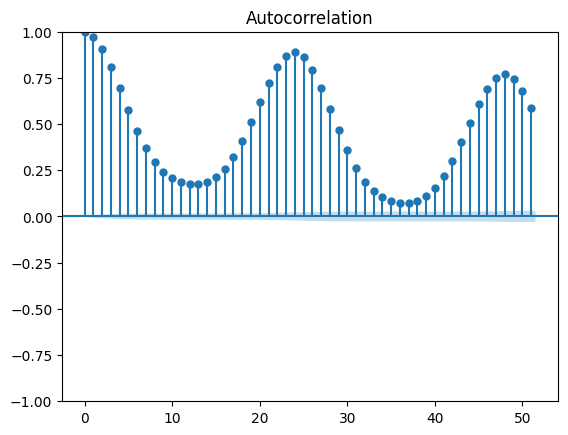

In [ ]:
acf = plot_acf(train['y'])

The ACF Plot is also indicating that the data is Seasonal. From here we can say that the Moving Average order should be either 0, 1 or 2. And the Seaonal MA order should be either 1 or 2.

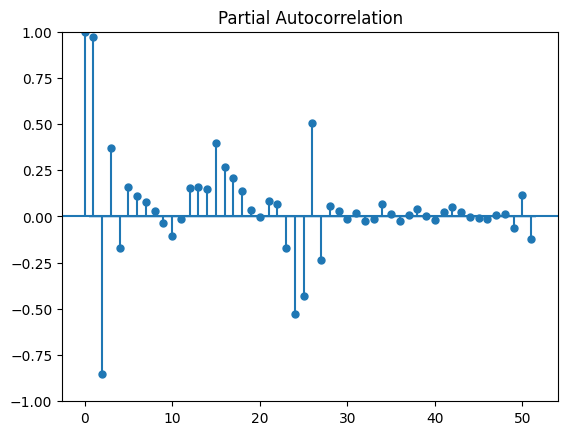

In [ ]:
pacf = plot_pacf(train['y'])

From the PACF Plot we infer the order of the Auto Regressive part. Here also we can see that the data is seasonal.

### Stationarity

In [ ]:
# Performing the ADF test

result = adfuller(train['y'])
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


To find whether the data is stationary or not we perform the ADFuller Test. Here we can see that the data is stationary.

### Sarimax Model Training

Could not fit SARIMAX on the whole training data thus using a smaller subset

In [ ]:
# Converting ds to index and setting and hourly frequency

In [ ]:
train = train.set_index('ds')
train = train.asfreq('h')

test = test.set_index('ds')
test = test.asfreq('h')

In [ ]:
test.index, train.index

(DatetimeIndex(['2015-04-09 10:00:00', '2015-04-09 11:00:00',
                '2015-04-09 12:00:00', '2015-04-09 13:00:00',
                '2015-04-09 14:00:00', '2015-04-09 15:00:00',
                '2015-04-09 16:00:00', '2015-04-09 17:00:00',
                '2015-04-09 18:00:00', '2015-04-09 19:00:00',
                ...
                '2018-08-02 15:00:00', '2018-08-02 16:00:00',
                '2018-08-02 17:00:00', '2018-08-02 18:00:00',
                '2018-08-02 19:00:00', '2018-08-02 20:00:00',
                '2018-08-02 21:00:00', '2018-08-02 22:00:00',
                '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
               dtype='datetime64[ns]', name='ds', length=29079, freq='h'),
 DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
                '2002-01-01 03:00:00', '2002-01-01 04:00:00',
                '2002-01-01 05:00:00', '2002-01-01 06:00:00',
                '2002-01-01 07:00:00', '2002-01-01 08:00:00',
                '2002-01-01 09:00:00

In [ ]:
# checked for null values
# because if there were some missing datetime points
# then df.asfreq() would set it to na

pd.DataFrame({'Test': test.isna().sum(),
              'Train': train.isna().sum()})

,Test,Train
weekday_Friday,0,0
weekday_Monday,0,0
weekday_Saturday,0,0
weekday_Sunday,0,0
weekday_Thursday,0,0
weekday_Tuesday,0,0
weekday_Wednesday,0,0
season_Fall,0,0
season_Spring,0,0
season_Summer,0,0


In [ ]:
order = (1, 1, 0)
seasonal_order = (1, 1, 0, 24)

In [ ]:
model = SARIMAX(endog = train['y'].loc['2013-07'],
                exog = train[FEATURES].loc['2013-07'],
                order = order,
                seasonal_order = seasonal_order)

In [ ]:
%%time
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 1min 23s, sys: 234 ms, total: 1min 24s
Wall time: 1min 13s


In [ ]:
print(model_fit.mle_retvals)

{'fopt': np.float64(-0.08024425701225436), 'gopt': array([ 1.86398485e+00,  3.29575152e+00,  0.00000000e+00,  0.00000000e+00,
        6.15068348e+00,  9.01692805e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.26433325e-08,  0.00000000e+00,  1.97874264e+07,
       -1.30589983e-09, -3.36938810e-08, -5.37070388e-08,  8.34721181e-08,
        0.00000000e+00, -3.45931617e-08,  6.15068348e+00,  6.22474831e+09,
        1.24102054e+11,  2.24898558e+10,  8.49068527e+04,  3.81825379e+05,
       -5.37070388e-08, -1.06302527e+03, -6.98285079e-01, -9.48905917e+05]), 'fcalls': 609, 'warnflag': 2, 'converged': False, 'iterations': 0}


Tried various methods but still SARIMAX model is not converging

## XGBoost

Thought of trying XGBoost if we can get any better result than the Prophet Model.

### Train and Test Set

In [ ]:
# the Features and the Target Columns

FEATURES = [x for x in list(train.columns)]
FEATURES.pop(11)
TARGET = ['y']

In [ ]:
# Creating the training and testing set

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Model Training

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       eval_metric=['rmse', 'mape'],
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state = 42
                       )

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
        )

[0]	validation_0-rmse:32631.60063	validation_0-mape:0.98995	validation_1-rmse:31440.88799	validation_1-mape:0.98991
[1]	validation_0-rmse:32306.34634	validation_0-mape:0.98002	validation_1-rmse:31126.42032	validation_1-mape:0.97993
[2]	validation_0-rmse:31984.35466	validation_0-mape:0.97019	validation_1-rmse:30815.05730	validation_1-mape:0.97006
[3]	validation_0-rmse:31665.58836	validation_0-mape:0.96045	validation_1-rmse:30506.86083	validation_1-mape:0.96028
[4]	validation_0-rmse:31350.01134	validation_0-mape:0.95082	validation_1-rmse:30201.77944	validation_1-mape:0.95061
[5]	validation_0-rmse:31037.60129	validation_0-mape:0.94128	validation_1-rmse:29899.78885	validation_1-mape:0.94103
[6]	validation_0-rmse:30728.31429	validation_0-mape:0.93183	validation_1-rmse:29600.73090	validation_1-mape:0.93154
[7]	validation_0-rmse:30422.12886	validation_0-mape:0.92248	validation_1-rmse:29304.60610	validation_1-mape:0.92215
[8]	validation_0-rmse:30119.01261	validation_0-mape:0.91322	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=['rmse', 'mape'],
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
accuracy_metric(y_test, y_pred)

MAE: 941.0096435546875
RMSE: 1204.857564195868
MAPE: 3.0391 %


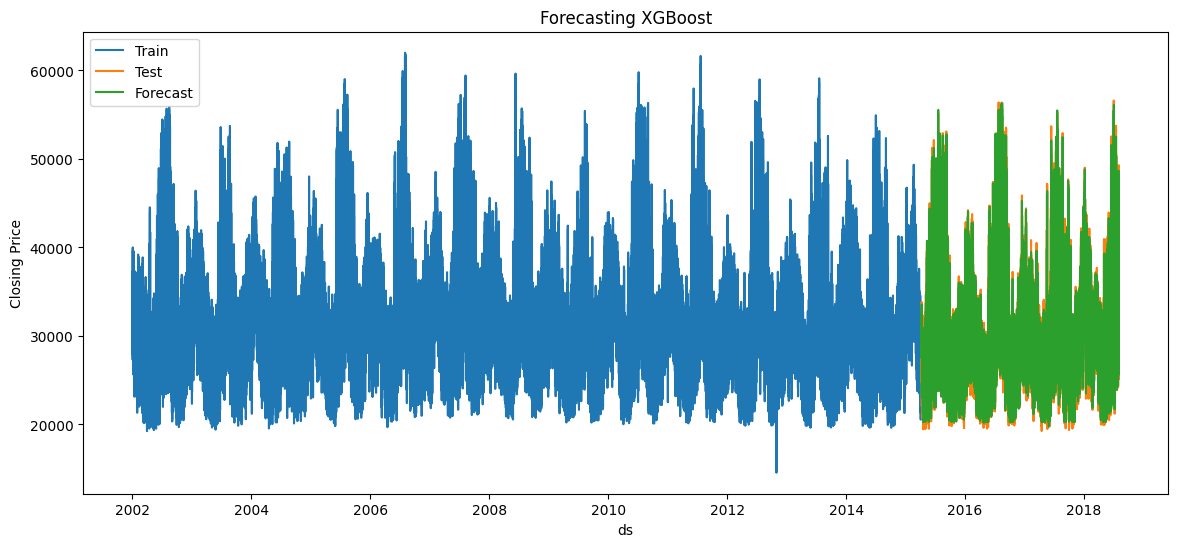

In [ ]:
# Plotting the Train Test and Forecasted Values

plt.figure(figsize = (14, 6))
sns.lineplot(y = y_train.squeeze(), x = X_train.index, label = 'Train')
sns.lineplot(y = y_test.squeeze(), x = X_test.index, label = 'Test')
sns.lineplot(y = y_pred.squeeze(), x = X_test.index, label = 'Forecast')
plt.title('Forecasting XGBoost')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### Parameter Tuning

In [ ]:
# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 3000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0.0, 5.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 5.0)

    # Create the RandomForestClassifier with suggested hyperparameters
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        gamma = gamma,
        reg_lambda = reg_lambda,
        n_estimators = n_estimators,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_percentage_error').mean()

    return -score  # Return the accuracy score for Optuna to maximize

In [ ]:
# Create a study object and optimize the objective function
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50, show_progress_bar = True)  # Run 50 trials to find the best hyperparameters

[I 2025-10-25 08:39:43,855] A new study created in memory with name: no-name-14ae3462-8d31-49b3-8002-37c7ca06dfb5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-25 08:40:34,095] Trial 0 finished with value: 0.02773508553703626 and parameters: {'n_estimators': 3000, 'max_depth': 3, 'learning_rate': 0.06093020528087245, 'subsample': 0.6322436471215089, 'colsample_bytree': 0.5911409380240237, 'min_child_weight': 2, 'gamma': 1.283556341685148, 'reg_lambda': 1.3261221737319162, 'reg_alpha': 2.107337335346704}. Best is trial 0 with value: 0.02773508553703626.
[I 2025-10-25 08:41:42,301] Trial 1 finished with value: 0.032095840821663536 and parameters: {'n_estimators': 2400, 'max_depth': 6, 'learning_rate': 0.13900660815419916, 'subsample': 0.9376327845708414, 'colsample_bytree': 0.604940332344649, 'min_child_weight': 5, 'gamma': 1.295103502896095, 'reg_lambda': 5.854754153083734, 'reg_alpha': 1.6967674459538644}. Best is trial 0 with value: 0.02773508553703626.
[I 2025-10-25 08:42:24,832] Trial 2 finished with value: 0.02700768845776717 and parameters: {'n_estimators': 1200, 'max_depth': 7, 'learning_rate': 0.024004068121259325, 'subsampl

In [ ]:
# Best trial
print(study.best_trial.params)
print(study.best_trial.value)

{'n_estimators': 900, 'max_depth': 9, 'learning_rate': 0.01000264563975656, 'subsample': 0.829477311690503, 'colsample_bytree': 0.9773295784710946, 'min_child_weight': 3, 'gamma': 2.0321612285050428, 'reg_lambda': 2.214407584196923, 'reg_alpha': 0.6750156775724145}
0.025689696272214253


In [ ]:
df_trials = study.trials_dataframe()
df_trials.head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.027735,2025-10-25 08:39:43.876037,2025-10-25 08:40:34.095030,0 days 00:00:50.218993,0.591141,1.283556,0.060930,3,2,3000,2.107337,1.326122,0.632244,COMPLETE
1,1,0.032096,2025-10-25 08:40:34.099610,2025-10-25 08:41:42.301278,0 days 00:01:08.201668,0.604940,1.295104,0.139007,6,5,2400,1.696767,5.854754,0.937633,COMPLETE
2,2,0.027008,2025-10-25 08:41:42.305795,2025-10-25 08:42:24.832489,0 days 00:00:42.526694,0.701104,2.956834,0.024004,7,6,1200,2.172643,2.566914,0.614352,COMPLETE
3,3,0.030657,2025-10-25 08:42:24.837657,2025-10-25 08:43:33.060236,0 days 00:01:08.222579,0.567837,1.285074,0.100304,5,5,2900,0.327179,5.254779,0.551452,COMPLETE
4,4,0.027203,2025-10-25 08:43:33.063622,2025-10-25 08:44:03.903328,0 days 00:00:30.839706,0.725529,2.556766,0.052104,6,6,1000,1.526800,9.396989,0.769156,COMPLETE


In [ ]:
best_params_mape = df_trials[df_trials['value'] == df_trials['value'].min()].transpose()
best_params_mape

,47
number,47
value,0.02569
datetime_start,2025-10-25 09:10:51.164348
datetime_complete,2025-10-25 09:11:58.152289
duration,0 days 00:01:06.987941
params_colsample_bytree,0.97733
params_gamma,2.032161
params_learning_rate,0.010003
params_max_depth,9
params_min_child_weight,3


In [ ]:
# Training a XGBClassifierr using the best hyperparameters from Optun
best_model = xgb.XGBRegressor(n_estimators = 900,
                              max_depth = 9,
                              learning_rate = 0.01000264563975656,
                              subsample = 0.829477311690503,
                              colsample_bytree = 0.9773295784710946,
                              min_child_weight = 3,
                              gamma = 2.0321612285050428,
                              reg_lambda = 2.214407584196923,
                              reg_alpha = 0.675015677572414,
                              random_state=42
                              )

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
accuracy_metric(y_test, y_pred)

MAE: 38.555397033691406
RMSE: 82.11292660016296
MAPE: 0.1210 %


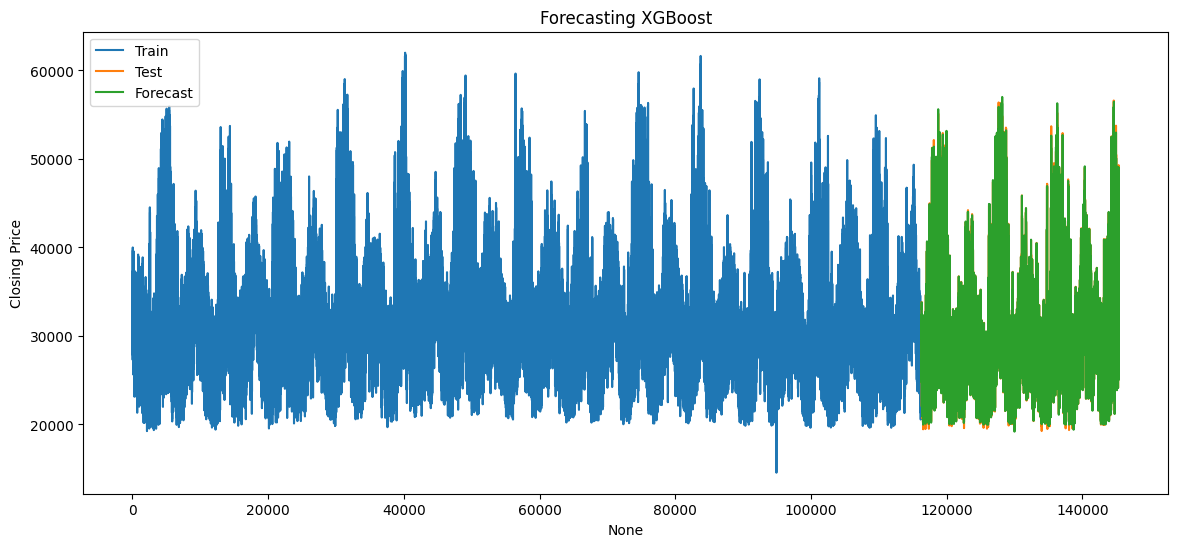

In [ ]:
# Plotting the Train Test and Forecasted Values

plt.figure(figsize = (14, 6))
sns.lineplot(y = y_train.squeeze(), x = X_train.index, label = 'Train')
sns.lineplot(y = y_test.squeeze(), x = X_test.index, label = 'Test')
sns.lineplot(y = y_pred.squeeze(), x = X_test.index, label = 'Forecast')
plt.title('Forecasting XGBoost')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
cross_val_acc(best_model, X_train, y_train)

MAE: 42.50860850016276
RMSE: 159.45374994773823
MAPE: 0.1199 %


We can see that the MAPE is extremely low, it might overfit. So, checking the residuals to draw conclusion.

In [ ]:
residuals = y_test.squeeze() - y_pred

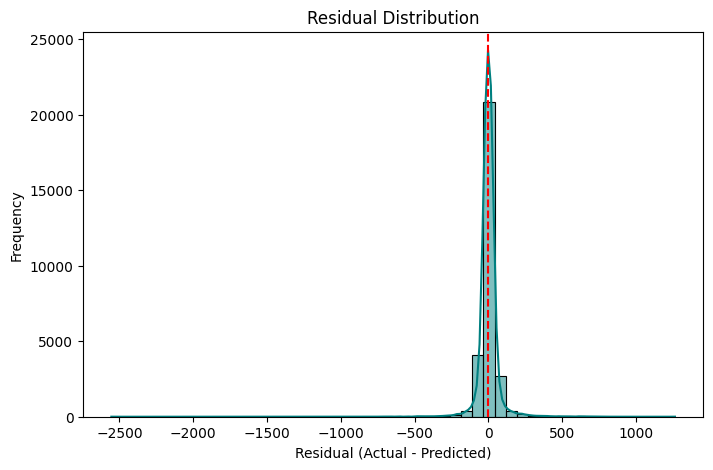

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

### 1. Shape and Center of the Distribution

- The residuals are tightly centered around 0, which is a very good sign.
 This means the model is not systematically overpredicting or underpredicting.

- The distribution is highly peaked (leptokurtic), most residuals are extremely close to zero. That indicates very high accuracy for most predictions.

### 2. Spread of the Distribution

- The x-axis spans roughly –2500 to +1000 MW, but nearly all residuals lie in a very narrow range near –200 to +200 MW.

- This tight clustering means low variance in errors, confirming the low RMSE (82 MW) and MAPE (0.12%) metrics.

### 3. Skewness

- The tail on the left (negative side) seems slightly longer than on the right, suggesting minor left skew. That means the model occasionally slightly overestimates the target values (predicted > actual).

- However, the skew is very minimal — not enough to indicate bias.

### 4. Kurtosis

- The sharp central spike and very short tails indicate low noise and high precision.

- This shows that the model predictions are extremely consistent for the majority of samples, confirming strong fit.



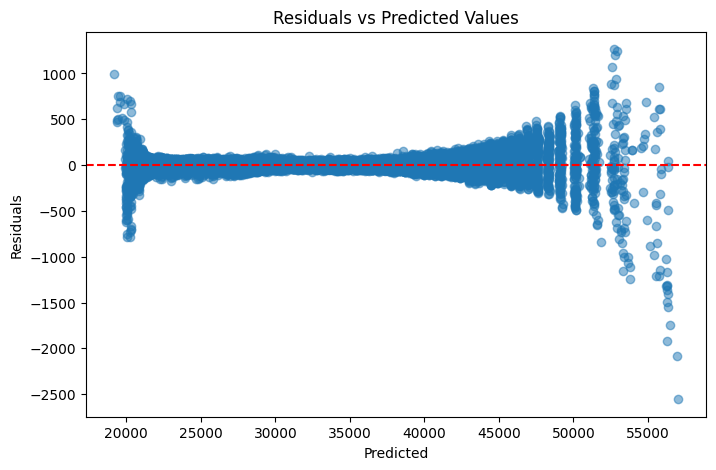

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

### 1. General Pattern

- The residuals are tightly clustered around the horizontal zero line, which means there’s no major systematic bias (i.e., the model doesn’t consistently over- or under-predict).

- The spread of residuals is narrow and centered around 0 across most of the predicted range — this confirms good predictive consistency.

### 2. Variance Pattern (Homoscedasticity)

- The residual spread increases slightly as the predicted values get larger (i.e., the “funnel” shape at the right side).

- This pattern indicates mild heteroscedasticity — larger energy consumption values (predicted > 50,000 MW) have slightly higher uncertainty in prediction.

### 3. Outliers

- A few points show residuals beyond ±2000 MW, especially at the extreme right (high predicted demand).

- These are likely unusual consumption peaks or outliers in the dataset (e.g., special events, weather anomalies, or holidays) that the model wasn’t trained to fully capture.

### 4. Mean Line Check

- The red dashed line (residual = 0) cuts symmetrically through the middle of the cloud — perfect alignment.

- The residuals are evenly distributed above and below the line across all prediction ranges — no visible curvature.

> Residuals are random and centered

> No pattern in residual vs predicted


# Best Model


 > The Best Model till now is the XGBoost Model after HyperParameter Tuning with MAPE of 0.1199 %
